In [55]:
%%capture 
!pip install -r requirements.txt

In [56]:
import torch
import numpy as np
torch.manual_seed(7777)
np.random.seed(7777)

device = torch.device('cpu')

# print('Training will be done on the ' + 'GPU' if torch.cuda.is_available() else 'CPU')

In [57]:
from enum import Enum, StrEnum

class Scaling(Enum):
    INDEPENDENT = 1
    JOINT = 2

class DatasetType(StrEnum):
    TRAIN = 'trn'
    TEST = 'tst'
    VALIDATION = 'trn'

# Global variable to enable debug mode
DEBUG = True

#### Data loading & pre-processing functions

In [58]:
import pandas as pd
import numpy as np
from sklearn import preprocessing


# *Helper function to preprocess the RSSI data
def preprocess_rssi_data(df_rssi: pd.DataFrame, scaling_strategy: Scaling) -> pd.DataFrame:
    """
    This function preprocesses the training data by:
    1. Replacing all 100 values with -110 (ensures continuity of data)
    2. Separating the RSS values from the labels
    3. Scaling the data to have zero mean and unit variance

    Parameters:
    - train: The training data to be preprocessed
    - scaling_strategy: The scaling strategy to be used (INDEPENDENT or JOINT)
    """
    
    # 1. replace all 100 values with -110 (ensures continuity of data)
    df = df_rssi.replace(100, -110)
    
    # 2. Separate the RSS values from the labels
    rssiValues = df.iloc[:, :-3]
    labels = df.iloc[:, -3:]
    
    # 3. Scale the data to have zero mean and unit variance
    # This is done either independently for each AP or jointly for all APs
    if scaling_strategy == Scaling.INDEPENDENT:
        scaler = preprocessing.StandardScaler()

        scaled_rss = scaler.fit_transform(rssiValues)
        df_scaled_rss = pd.DataFrame(scaled_rss, columns=rssiValues.columns)
        df = pd.concat([df_scaled_rss, labels], axis=1)
    
    elif scaling_strategy == Scaling.JOINT:
        flattened = rssiValues.values.flatten()
        global_mean = np.mean(flattened)
        global_std = np.std(flattened)
        
        scaled_rss = (rssiValues - global_mean) / global_std
        df = pd.concat([scaled_rss, labels], axis=1)
        df = df.reset_index(drop=True)
    
    else: 
        raise NotImplementedError("Specified scaling strategy is not implemented, use either Scaling.INDEPENDENT or Scaling.JOINT.")
    
    return df

# # *Load and pre-process the training data
# def get_preprocessed_training_data(data_path: str, training_months: list[str], num_APs: int, scaling_strategy: Scaling, floor: int) -> pd.DataFrame:
#     """
#     This function loads and preprocesses the training data from the specified training months and floor.

#     Parameters:
#     - data_path: The path to the data
#     - training_months: The list of training months to be used
#     - num_APs: The number of access points
#     - scaling_strategy: The scaling strategy to be used (INDEPENDENT or JOINT)
#     - floor: The floor to be used
#     """
#     # Since the csv files do not have column names, we define these first.
#     list_of_APs = ["AP" + str(i) for i in range(0, num_APs)]

#     # Load the training data from all specified training sets.  
#     df_rss = pd.concat([pd.read_csv(data_path + training_set + 'trn01rss.csv', names=list_of_APs) for training_set in training_months])
#     df_rss = df_rss.reset_index(drop=True)
    
#     # Get all x,y,floor labels (gotten from data_path + training_month + 'trn01crd.csv')
#     df_labels = pd.concat([pd.read_csv(data_path + training_set + 'trn01crd.csv', names=['x', 'y', 'floor']) for training_set in training_months])
#     df_labels = df_labels.reset_index(drop=True)

#     # Add the labels to the pre-processed data
#     df_labeled = pd.concat([df_rss, df_labels], axis=1)
    
#     # Filter the data to only include the specified floor
#     df_labeled = df_labeled[df_labeled['floor'] == floor]

#     # Pre-processing of the training data
#     df_train = preprocess_rssi_data(df_labeled, scaling_strategy)
    
#     return df_train

# *Load and pre-process the data
def get_preprocessed_dataset(data_path: str, months: list[str], sets: list[str], type: DatasetType, num_APs: int, scaling_strategy: Scaling, floor: int) -> pd.DataFrame:
    """
    This function loads and preprocesses the training data from the specified training months and floor.

    Parameters:
    - data_path: The path to the data
    - months: The list of months to be used
    - sets: The list of set numbers to be used
    - type: The type of dataset to be made (TRAIN, TEST or VALIDATION)
    - num_APs: The number of access points
    - scaling_strategy: The scaling strategy to be used (INDEPENDENT or JOINT)
    - floor: The floor to be used
    """
    # Since the csv files do not have column names, we define these first.
    list_of_APs = ["AP" + str(i) for i in range(0, num_APs)]

    # Load the test data from all specified test sets.  
    df_test_rss = pd.concat([pd.read_csv(data_path + month + '/' + type + set + 'rss.csv', names=list_of_APs) for month in months for set in sets])
    df_test_rss = df_test_rss.reset_index(drop=True)
    
    # Get all x,y,floor labels
    df_test_labels = pd.concat([pd.read_csv(data_path + month + '/' + type + set + 'crd.csv', names=['x', 'y', 'floor']) for month in months for set in sets])
    df_test_labels = df_test_labels.reset_index(drop=True)

    # Add the labels to the pre-processed data
    df_test_labeled = pd.concat([df_test_rss, df_test_labels], axis=1)
    
    # Filter the data to only include the specified floor
    df_test_labeled = df_test_labeled[df_test_labeled['floor'] == floor]

    # Pre-processing of the training data
    df_test = preprocess_rssi_data(df_test_labeled, scaling_strategy)
    
    return df_test
    

#### SETUP

In [59]:
from sklearn.model_selection import train_test_split

data_path = './data/V1.0/'
training_months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
sets = ['01']
type = DatasetType.TRAIN
num_APs = 448
scaling_strategy = Scaling.JOINT
floor = 3

df_full = get_preprocessed_dataset(data_path, training_months, sets, type, num_APs, scaling_strategy, floor)

df_x = df_full.iloc[:, :-3] # Just the RSSI values
df_y = df_full.iloc[:, -3:-1] # Just the x and y coordinates (no floor)

df_train_x, df_val_x, df_train_y, df_val_y = train_test_split(df_x, df_y, test_size=0.1, random_state=7777)

if DEBUG: print('df_full:', df_full.shape)
if DEBUG: print('df_train_x:', df_train_x.shape)
if DEBUG: print('df_train_y:', df_train_y.shape)
if DEBUG: print('df_val_x:', df_val_x.shape)
if DEBUG: print('df_val_y:', df_val_y.shape)



df_full: (4320, 451)
df_train_x: (3888, 448)
df_train_y: (3888, 2)
df_val_x: (432, 448)
df_val_y: (432, 2)


In [60]:
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
sets = ['01', '02', '03'] # 01 Corresponds to the same locations as the training set - All with same direction
type = DatasetType.TEST

df_test_full = get_preprocessed_dataset(data_path, months, sets, type, num_APs, scaling_strategy, floor)
df_test_x = df_test_full.iloc[:, :-3] # Just the RSSI values
df_test_y = df_test_full.iloc[:, -3:-1] # Just the x and y coordinates (no floor)

if DEBUG: print('df_test01-02-03_full:', df_test_full.shape)

df_test01-02-03_full: (12960, 451)


In [61]:
# months = ['01']
# sets = ['02', '03', '04']
# type = DatasetType.VALIDATION

# df_val_full = get_preprocessed_dataset(data_path, months, sets, type, num_APs, scaling_strategy, floor)
# df_val_x = df_val_full.iloc[:, :-3] # Just the RSSI values
# df_val_y = df_val_full.iloc[:, -3:-1] # Just the x and y coordinates (no floor)

# if DEBUG: print('df_val_full:', df_val_full.shape)

In [62]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Since the implementations will be made in PyTorch, we convert the data to PyTorch tensors
X_train_tensor = torch.tensor(df_train_x.values, dtype=torch.float32)
y_train_tensor = torch.tensor(df_train_y.values, dtype=torch.float32)
X_test_tensor = torch.tensor(df_test_x.values, dtype=torch.float32)
y_test_tensor = torch.tensor(df_test_y.values, dtype=torch.float32)
X_val_tensor = torch.tensor(df_val_x.values, dtype=torch.float32)
y_val_tensor = torch.tensor(df_val_y.values, dtype=torch.float32)

# Get the data via DataLoaders
t_training = TensorDataset(X_train_tensor, y_train_tensor)
t_test = TensorDataset(X_test_tensor, y_test_tensor)
t_val = TensorDataset(X_val_tensor, y_val_tensor)

# train_loader = DataLoader(t_training, batch_size=16, shuffle=True)
# test_loader = DataLoader(t_test, batch_size=16, shuffle=True)
# val_loader = DataLoader(t_val, batch_size=16, shuffle=True)



# MultiLayer Perceptrons

#### Full-Input MLP
This network takes the full input of 448 features to perform x,y predictions.

In [63]:
import torch.nn as nn
import copy

class MLP(nn.Module):
    def __init__(self, hidden_layer_sizes, dropout_rate, input_dim=448):
        super(MLP, self).__init__()
        
        layers = []
        
        # Make it easier to grid-search different sizes of hidden layers
        for hidden_dim in hidden_layer_sizes:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim # Update input_dim for next layer
        
        # At this point we know input_dim equals the output size of the last hidden layer, so we can re-use it here.
        layers.append(nn.Linear(input_dim, 2)) # x,y output
        
        # Construct the actual model based on the layers defined above.
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)
    

def train_MLP(model, train_loader, val_loader, criterion, optimizer, epochs):
    
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Early stopping variables
    best_model_wts = None
    best_val_loss = np.inf
    epochs_without_improvement = 0
    epochs_to_use = 0
    patience = 10
    
    # Training/Validation loops
    for epoch in range(epochs):
        model.train() # Sets the model to training mode
        running_loss = 0.0 # Keep track of the (MSE) loss
        
        # Actual training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) 
            
            # Extra case for LGFBS
            def closure():
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    return loss
            
            if isinstance(optimizer, torch.optim.LBFGS):
                optimizer.step(closure)
                loss = closure()
            
            else:
                optimizer.zero_grad() # Reset gradients from last iteration
                outputs = model(inputs) # Forward pass
                loss = criterion(outputs, labels) # Compute the loss (MSE) between the predictions and the ground-truth labels
                loss.backward() # Perform backpropagation
                optimizer.step() # Update model parameters (weights) based on the gradients computed during backpropagation
            
            running_loss += loss.item() # Running loss is the sum of the losses for all batches FOR THE CURRENT EPOCH 
        
        # Validation time
        model.eval()
        val_loss = 0.0 # Accumulated validation loss
        
        # Validation loop
        with torch.no_grad(): # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device) # Move data to GPU if available
                
                outputs = model(inputs) # Forward pass to get predictions
                loss = criterion(outputs, labels) # Compute the loss (MSE) between the predictions and the ground-truth labels
                val_loss += loss.item() # Accumulate the validation loss for this epoch <-- TODO: (Make list for final model to plot)
        
        avg_val_loss = val_loss / len(val_loader)
        
        # Print the loss for this epoch
        print(f'Epoch {epoch+1}/{epochs} - Avg Training Loss: {running_loss/len(train_loader)} - Avg Validation Loss: {val_loss/len(val_loader)}')
    
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_to_use = epoch+1
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch+1} epochs without improvement. Use model from epoch {epochs_to_use}')
            break
    
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    print('Finished Training')
    return best_val_loss, model

#### Reduced-Input MLP
Use either stacked or deep autoencoder to reduce the input space before training a MLP network

In [64]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simple auto-encoder class with a single hidden layer
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder - Compress input data
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Decoder - Reconstruct input data
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded



# Function to train a *single* autoencoder
def train_autoencoder(autoencoder, data_loader, criterion, optimizer, epochs):
    autoencoder.to(device) # Move model to GPU if available
    
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(epochs):
        autoencoder.train() # Enable training mode
        running_loss = 0.0 # Running loss for this epoch
        
        for inputs, _ in data_loader: # Unsupervised learning, so we don't need the labels
            inputs = inputs.to(device) # Move data to GPU if available
            
            optimizer.zero_grad() # Reset gradients from last iteration
            
            _, outputs = autoencoder(inputs) # Forward pass - only care about the reconstructed data to compute the loss with.
            loss = criterion(outputs, inputs) # Compute the loss between the reconstructed data and the original input
            
            loss.backward() # Compute gradients
            optimizer.step() # Update model params based on gradients
            
            running_loss += loss.item() # Accumulate loss, item() is used to extract the actual loss value from the tensor
        
        print(f'Epoch {epoch+1}/{epochs} - Avg Training Loss: {running_loss/len(data_loader)}')

# Function to, sequentially, train a stack of autoencoders
def train_stacked_autoencoders(train_data, input_dim, num_encoders, epochs=20):
    train_dataset = TensorDataset(train_data, train_data) # Autoencoders are unsupervised, so the input data is also the target data
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    encoders = [] # List to store the trained autoencoders
    current_dim = input_dim # The current input dimension
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for enc_out in num_encoders:
        autoencoder = Autoencoder(current_dim, enc_out).to(device) # Create a new autoencoder
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
        
        # Train the autoencoder
        train_autoencoder(autoencoder, train_loader, criterion, optimizer, epochs)
        
        encoders.append(autoencoder) # Add the trained autoencoder to the list
        
        # Update input data to the encoded data from the current autoencoder
        train_data = get_encoded_data(autoencoder, train_loader)
        train_dataset = TensorDataset(train_data, train_data)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        current_dim = enc_out # Update the current input dimension
    
    return encoders

# Utility function to get the encoded data from the autoencoder
def get_encoded_data(autoencoder, data_loader):
    encoded_data = []

    autoencoder.eval() # Set model to evaluation mode
    
    with torch.no_grad(): # No need to compute gradients during inference
        for inputs, _ in data_loader: # Unsupervised learning, so we don't need the labels
            inputs = inputs.to(device) # Move data to GPU if available
            
            encoded, _ = autoencoder(inputs) # Forward pass - only care about the encoded data
            encoded_data.append(encoded)
    
    return torch.cat(encoded_data, dim=0) # Concatenate all encoded data into a single tensor

def stacked_encode_data(data, encoders):
    """
    Function to encode data using a stack of autoencoders.
    Assumes that the autoencoders have already been trained.
    
    Parameters:
    - data: The data to be encoded
    - encoders: The stack of trained autoencoders to be used (provided as ordered list)
    """
    with torch.no_grad():
        for encoder in encoders:
            data = data.to(device)
            data, _ = encoder(data)
    
    return data

#### Hyper-parameter tuning

In [65]:
import optuna

def MLP_full_optimize(trial, optim : str = 'Adam') -> float:
    # Hyper-parameters to be optimized
    # hidden_layer_size = trial.suggest_categorical('hidden_layer_size', [700, 512, 256, 128])
    hidden_layer_count = trial.suggest_int('hidden_layer_count', 2, 4) # inclusive
    hidden_layer_sizes = [trial.suggest_categorical(f'hidden_layer_size_{i}', [32, 16, 8, 4, 2]) for i in range(hidden_layer_count)]
    # hidden_layer_sizes = (hidden_layer_size,) * hidden_layer_count
    
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    lr = trial.suggest_float('lr', 0.001, 0.01)
    batch_size = trial.suggest_int('batch_size', 16, 512, step=16)
    epochs = trial.suggest_int('epochs', 50, 150)
    
    # Initialize the model
    model = MLP(hidden_layer_sizes, dropout_rate)
    
    if optim.lower() == 'adam': optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optim.lower() == 'lbfgs': optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
    else : raise ValueError('Unknown optimizer')
    
    criterion = nn.MSELoss()
    
    # Use chosen batch size instead of pre-defined one
    train_loader = DataLoader(t_training, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(t_val, batch_size=batch_size, shuffle=True)
    
    # Train the model, return validation loss
    val_loss, trained_model = train_MLP(model, train_loader, val_loader, criterion, optimizer, epochs)
    
    return val_loss, trained_model




def MLP_SAE_optimize(trial, SAE, input_size, optim : str = 'Adam') -> float:
    # Hyper-parameters to be optimized
    
    # hidden_layer_size = trial.suggest_categorical('hidden_layer_size', [256, 128, 64, 32, 16])
    hidden_layer_count = trial.suggest_int('hidden_layer_count', 2, 4) # inclusive
    hidden_layer_sizes = [trial.suggest_categorical(f'hidden_layer_size_{i}', [32, 16, 8, 4, 2]) for i in range(hidden_layer_count)]
    
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    lr = trial.suggest_float('lr', 0.001, 0.01)
    batch_size = trial.suggest_int('batch_size', 16, 512, step=16)
    epochs = trial.suggest_int('epochs', 50, 150)
    
    # Initialize the model
    model = MLP(hidden_layer_sizes, dropout_rate, input_size)
    
    
    if optim.lower() == 'adam': optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optim.lower() == 'lbfgs': optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
    else : raise ValueError('Unknown optimizer')
    
    criterion = nn.MSELoss()
    
    # Use chosen batch size instead of pre-defined one
    
    # Encode training and validation data using the stacked autoencoders in SAE
    train_data_encoded = stacked_encode_data(X_train_tensor, SAE)
    val_data_encoded = stacked_encode_data(X_val_tensor, SAE)
    
    train_loader = DataLoader(TensorDataset(train_data_encoded, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_data_encoded, y_val_tensor), batch_size=batch_size, shuffle=True)
    
    
    # Train the model, return validation loss
    val_loss, trained_model = train_MLP(model, train_loader, val_loader, criterion, optimizer, epochs)
    
    return val_loss, trained_model

In [66]:

# Use the following booleans to enable or disable the grid-search for the different models.
# After running the grid-search, train the final models with the best hyperparameters.

SEARCH_MLP_FULL = True
SEARCH_MLP_REDUCED_128 = True
SEARCH_MLP_REDUCED_64 = True

TRIALS_MLP = 20

In [67]:
%%capture MLP_opt_out

import optuna

def pretty_print_study(study):
    print('====================================')
    print('Number of finished trials:', len(study.trials))
    print('Best trial:')
    trial = study.best_trial
    print('     Trial Number: ', trial.number)
    print('     Duration: ', trial.duration.total_seconds())
    print('     Value: ', trial.value)
    print('     Params: ')
    for key, value in trial.params.items():
        print(f'         {key}: {value}')

def save_best_MLP(study, path, SAE=None, input_size=448):
    best_trial = study.best_trial
    
    hidden_layer_sizes = [best_trial.params[f'hidden_layer_size_{i}'] for i in range(best_trial.params['hidden_layer_count'])]
    model = MLP(hidden_layer_sizes, best_trial.params['dropout_rate'], input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_trial.params['lr'])
    criterion = nn.MSELoss()
    
    if SAE is not None: # Encode training and validation data using the stacked autoencoders in SAE
        train_data_encoded = stacked_encode_data(X_train_tensor, SAE)
        val_data_encoded = stacked_encode_data(X_val_tensor, SAE)
        
        train_loader = DataLoader(TensorDataset(train_data_encoded, y_train_tensor), batch_size=best_trial.params['batch_size'], shuffle=True)
        val_loader = DataLoader(TensorDataset(val_data_encoded, y_val_tensor), batch_size=best_trial.params['batch_size'], shuffle=True)
    else :
        train_loader = DataLoader(t_training, batch_size=best_trial.params['batch_size'], shuffle=True)
        val_loader = DataLoader(t_val, batch_size=best_trial.params['batch_size'], shuffle=True)
    
    val_loss, trained_model = train_MLP(model, train_loader, val_loader, criterion, optimizer, best_trial.params['epochs'])
    
    torch.save(trained_model.state_dict(), path)

if SEARCH_MLP_FULL:
    print('Starting MLP full grid search')

    # Optuna study object and direction (minimize validation loss)
    study = optuna.create_study(direction='minimize')
    # study.optimize(MLP_full_gridsearch, n_trials=2)
    study.optimize(lambda trial: MLP_full_optimize(trial, 'Adam')[0], n_trials=TRIALS_MLP)

    pretty_print_study(study)

    # Save trained model from best trial
    best_trial = study.best_trial
    save_best_MLP(study, f'./models/MLP/full_MLP.pth')
    
else: print('Skipping SEARCH_MLP_FULL')

print('\n====================================')
print('V results for SEARCH_MLP_REDUCED_128 V')
print('====================================\n')


if SEARCH_MLP_REDUCED_128:
    print('Starting MLP reduced grid search for 256-128 SAE')

    encoders = train_stacked_autoencoders(X_train_tensor, 448, [256, 128], 20)
    
    # Save the encoders for later use
    for i, enc in enumerate(encoders):
        torch.save(enc.state_dict(), f'./models/MLP/128_encoder_{int(256 * 0.5**i)}.pth')
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: MLP_SAE_optimize(trial, encoders, 128, 'Adam')[0], n_trials=TRIALS_MLP)
    
    pretty_print_study(study)
    save_best_MLP(study, f'./models/MLP/128_MLP.pth', encoders, 128)
    

else: print('Skipping SEARCH_MLP_REDUCED_128') 

print('\n====================================')
print('V results for SEARCH_MLP_REDUCED_64 V')
print('====================================\n')

if SEARCH_MLP_REDUCED_64:
    print('Starting MLP reduced grid search for 256-128-64 SAE')

    encoders = train_stacked_autoencoders(X_train_tensor, 448, [256, 128, 64], 20)
    
    # Save the encoders for later use
    for i, enc in enumerate(encoders):
        torch.save(enc.state_dict(), f'./models/MLP/64_encoder_{int(256 * 0.5**i)}.pth')
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: MLP_SAE_optimize(trial, encoders, 64, 'Adam')[0], n_trials=TRIALS_MLP)
    
    pretty_print_study(study)
    save_best_MLP(study, f'./models/MLP/64_MLP.pth', encoders, 64)

else: print('Skipping SEARCH_MLP_REDUCED_64')

[I 2024-06-15 22:39:43,605] A new study created in memory with name: no-name-7470c12e-7295-4565-a3ac-55d1338e9644
[I 2024-06-15 22:39:44,776] Trial 0 finished with value: 37.414798736572266 and parameters: {'hidden_layer_count': 2, 'hidden_layer_size_0': 4, 'hidden_layer_size_1': 8, 'dropout_rate': 0.35466506621678645, 'lr': 0.0011206114014395293, 'batch_size': 512, 'epochs': 60}. Best is trial 0 with value: 37.414798736572266.
[I 2024-06-15 22:39:47,187] Trial 1 finished with value: 5.724008083343506 and parameters: {'hidden_layer_count': 2, 'hidden_layer_size_0': 8, 'hidden_layer_size_1': 32, 'dropout_rate': 0.34452058694178056, 'lr': 0.009613009595144755, 'batch_size': 176, 'epochs': 85}. Best is trial 1 with value: 5.724008083343506.
[I 2024-06-15 22:39:51,573] Trial 2 finished with value: 17.228859265645344 and parameters: {'hidden_layer_count': 4, 'hidden_layer_size_0': 4, 'hidden_layer_size_1': 2, 'hidden_layer_size_2': 8, 'hidden_layer_size_3': 2, 'dropout_rate': 0.591048423338

In [68]:
from datetime import datetime
now = datetime.now()
filename = now.strftime("./optimization/MLP/MLP optimization 448AP - ""%Y-%m-%d-%H-%M-%S") + '.txt'

with open(filename, 'w') as f:
    f.write(MLP_opt_out.stdout)

# Kolmogorov Arnold Networks

#### Full-Input KAN
This network takes the full input of 448 features to perform x,y predictions.

In [69]:
import copy

def train_KAN(kan_model, train_loader, val_loader, criterion, optimizer, epochs):
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    kan_model.to(device) # Move model to GPU if available
    
    # Early stopping variables
    best_model_wts = None
    best_val_loss = np.inf
    epochs_without_improvement = 0
    epochs_to_use = 0
    patience = 10
    
    # Training loop
    for epoch in range(epochs):
        kan_model.train() # Sets the model to training mode
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move data to GPU if available
            
            def closure():
                optimizer.zero_grad()
                outputs = kan_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss
                
            if isinstance(optimizer, torch.optim.LBFGS):
                optimizer.step(closure)
                loss = closure()
            else:
                optimizer.zero_grad()
                outputs = kan_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() # Accumulate the loss for this epoch
        
        kan_model.eval()
        val_loss = 0.0
        
        # Validation loop
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = kan_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
        avg_val_loss = val_loss / len(val_loader)
        
        # Print the loss for this epoch
        print(f'Epoch {epoch+1}/{epochs} - Avg Training Loss: {running_loss/len(train_loader)} - Avg Validation Loss: {val_loss/len(val_loader)}')
    
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(kan_model.state_dict())
            epochs_to_use = epoch+1
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch+1} epochs without improvement. Use model from epoch {epochs_to_use}')
            break
        
    if best_model_wts is not None:
        kan_model.load_state_dict(best_model_wts)
    
    print('Finished Training')
    return best_val_loss, kan_model # Return the besaverage validation loss for final epoch (taking early stopping into account) AND the model itself (for evaluation use)

In [70]:
from fastkan import FastKAN as KAN
import optuna

def KAN_full_optimize(trial, optim : str = 'Adam') -> float:
    # Hyper-parameters to be optimized
    
    hidden_layer_count = trial.suggest_int('hidden_layer_count', 2, 4) # inclusive
    hidden_layer_sizes = [trial.suggest_categorical(f'hidden_layer_size_{i}', [32, 16, 8, 4, 2]) for i in range(hidden_layer_count)]
    kan_layers = [448] + hidden_layer_sizes + [2] # Ensure correct input/output size

    print(kan_layers)
    
    learning_rate = trial.suggest_float('lr', 0.001, 0.01)
    batch_size = trial.suggest_int('batch_size', 16, 512, step=16)
    epochs = trial.suggest_int('epochs', 50, 150)
    
    # Initialize the model
    model = KAN(kan_layers) # We use the FastKAN implementation.
    
    if optim.lower() == 'adam': optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optim.lower() == 'lbfgs': optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate)
    else : raise ValueError('Unknown optimizer')
    
    criterion = nn.MSELoss() # As we are doing regression
    
    # Use chosen batch size instead of pre-defined one
    train_loader = DataLoader(t_training, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(t_val, batch_size=batch_size, shuffle=True)
    
    # Train the model, return validation loss
    val_loss, trained_model = train_KAN(model, train_loader, val_loader, criterion, optimizer, epochs)
    
    return val_loss, trained_model



def KAN_SAE_optimize(trial, SAE, input_size, optim : str = 'Adam') -> float:
    # Hyper-parameters to be optimized
    
    hidden_layer_count = trial.suggest_int('hidden_layer_count', 2, 4) # inclusive
    hidden_layer_sizes = [trial.suggest_categorical(f'hidden_layer_size_{i}', [32, 16, 8, 4, 2]) for i in range(hidden_layer_count)]
    kan_layers = [input_size] + hidden_layer_sizes + [2] # Ensure correct input/output size
    
    print(kan_layers)
    
    lr = trial.suggest_float('lr', 0.001, 0.01)
    batch_size = trial.suggest_int('batch_size', 16, 512, step=16)
    epochs = trial.suggest_int('epochs', 50, 150)
    
    # Initialize the model
    model = KAN(kan_layers)
    
    if optim.lower() == 'adam': optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optim.lower() == 'lbfgs': optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
    else : raise ValueError('Unknown optimizer')
    
    criterion = nn.MSELoss()
    
    # Encode training and validation data using the stacked autoencoders in SAE
    train_data_encoded = stacked_encode_data(X_train_tensor, SAE)
    val_data_encoded = stacked_encode_data(X_val_tensor, SAE)
    
    train_loader = DataLoader(TensorDataset(train_data_encoded, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_data_encoded, y_val_tensor), batch_size=batch_size, shuffle=True)
    
    
    # Train the model, return validation loss
    val_loss, trained_model = train_KAN(model, train_loader, val_loader, criterion, optimizer, epochs)
    
    return val_loss, trained_model

In [71]:
# Use the following booleans to enable or disable the grid-search for the different models.
# After running the grid-search, train the final models with the best hyperparameters.

SEARCH_KAN_FULL = True 
SEARCH_KAN_REDUCED_128 = True
SEARCH_KAN_REDUCED_64 = True 

TRIALS_KAN = 20

In [72]:
%%capture KAN_opt_out

import optuna

def save_best_KAN(study, input_size, path, SAE=None):
    best_trial = study.best_trial
    
    kan_layers = [input_size] + [best_trial.params[f'hidden_layer_size_{i}'] for i in range(best_trial.params['hidden_layer_count'])] + [2]
    
    model = KAN(kan_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_trial.params['lr'])
    criterion = nn.MSELoss()
    
    if SAE is not None: # Encode training and validation data using the stacked autoencoders in SAE
        train_data_encoded = stacked_encode_data(X_train_tensor, SAE)
        val_data_encoded = stacked_encode_data(X_val_tensor, SAE)
        
        train_loader = DataLoader(TensorDataset(train_data_encoded, y_train_tensor), batch_size=best_trial.params['batch_size'], shuffle=True)
        val_loader = DataLoader(TensorDataset(val_data_encoded, y_val_tensor), batch_size=best_trial.params['batch_size'], shuffle=True)
    else :
        train_loader = DataLoader(t_training, batch_size=best_trial.params['batch_size'], shuffle=True)
        val_loader = DataLoader(t_val, batch_size=best_trial.params['batch_size'], shuffle=True)
    
    val_loss, trained_model = train_KAN(model, train_loader, val_loader, criterion, optimizer, best_trial.params['epochs'])
    
    torch.save(trained_model.state_dict(), path)



if SEARCH_KAN_FULL:
    print('Starting KAN full grid search')

    # Optuna study object and direction (minimize validation loss)
    study = optuna.create_study(direction='minimize')
    # study.optimize(MLP_full_gridsearch, n_trials=2)
    study.optimize(lambda trial: KAN_full_optimize(trial, 'Adam')[0], n_trials=TRIALS_KAN)

    pretty_print_study(study)
    save_best_KAN(study, 448, f'./models/KAN/full_KAN.pth')

else: print('Skipping SEARCH_KAN_FULL')

print('\n====================================')
print('V results for SEARCH_KAN_REDUCED_128 V')
print('====================================\n')

if SEARCH_KAN_REDUCED_128:
    print('Starting KAN reduced search for 256-128 SAE')

    encoders = train_stacked_autoencoders(X_train_tensor, 448, [256, 128], 20)
    
    # Save the encoders for later use
    for i, enc in enumerate(encoders):
        torch.save(enc.state_dict(), f'./models/KAN/128_encoder_{int(256 * 0.5**i)}.pth')
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: KAN_SAE_optimize(trial, encoders, 128, 'Adam')[0], n_trials=TRIALS_KAN)
    
    pretty_print_study(study)
    save_best_KAN(study, 128, f'./models/KAN/128_KAN.pth', encoders)

else: print('Skipping SEARCH_KAN_REDUCED_128') 

print('\n====================================')
print('V results for SEARCH_KAN_REDUCED_64 V')
print('====================================\n')

if SEARCH_KAN_REDUCED_64:
    print('Starting KAN reduced grid search for 256-128-64 SAE')

    encoders = train_stacked_autoencoders(X_train_tensor, 448, [256, 128, 64], 20)
    
    # Save the encoders for later use
    for i, enc in enumerate(encoders):
        torch.save(enc.state_dict(), f'./models/KAN/64_encoder_{int(256 * 0.5**i)}.pth')
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: KAN_SAE_optimize(trial, encoders, 64, 'Adam')[0], n_trials=TRIALS_KAN)
    
    pretty_print_study(study)
    save_best_KAN(study, 64, f'./models/KAN/64_KAN.pth', encoders)

else: print('Skipping SEARCH_KAN_REDUCED_64')

[I 2024-06-15 22:42:48,727] A new study created in memory with name: no-name-fe008b7f-f8be-4bab-99b5-4f4f35863b7f
[I 2024-06-15 22:42:56,136] Trial 0 finished with value: 1.6804826259613037 and parameters: {'hidden_layer_count': 2, 'hidden_layer_size_0': 32, 'hidden_layer_size_1': 8, 'lr': 0.0029974385320055232, 'batch_size': 336, 'epochs': 122}. Best is trial 0 with value: 1.6804826259613037.
[I 2024-06-15 22:42:58,608] Trial 1 finished with value: 13.584057331085205 and parameters: {'hidden_layer_count': 4, 'hidden_layer_size_0': 8, 'hidden_layer_size_1': 2, 'hidden_layer_size_2': 2, 'hidden_layer_size_3': 8, 'lr': 0.008653567797090464, 'batch_size': 352, 'epochs': 109}. Best is trial 0 with value: 1.6804826259613037.
[I 2024-06-15 22:43:08,458] Trial 2 finished with value: 6.466972282954624 and parameters: {'hidden_layer_count': 3, 'hidden_layer_size_0': 4, 'hidden_layer_size_1': 2, 'hidden_layer_size_2': 2, 'lr': 0.008182622943197545, 'batch_size': 64, 'epochs': 101}. Best is trial

In [73]:
from datetime import datetime
now = datetime.now()
filename = now.strftime("./optimization/KAN/KAN optimization 448AP - ""%Y-%m-%d-%H-%M-%S") + '.txt'

with open(filename, 'w') as f:
    f.write(KAN_opt_out.stdout)

# Evaluation

In [77]:
perform_evaluation = True


model_paths = {
    'MLP': {
        'full': './models/MLP/full_MLP.pth',
        '128': './models/MLP/128_MLP.pth',
        '64': './models/MLP/64_MLP.pth'
    },
    'KAN': {
        'full': './models/KAN/full_KAN.pth',
        '128': './models/KAN/128_KAN.pth',
        '64': './models/KAN/64_KAN.pth'
    }
}

SAE_paths = {
    'MLP': {
        '128': ['./models/MLP/128_encoder_256.pth', './models/MLP/128_encoder_128.pth'],
        '64': ['./models/MLP/64_encoder_256.pth', './models/MLP/64_encoder_128.pth', './models/MLP/64_encoder_64.pth']
    },
    'KAN': {
        '128': ['./models/KAN/128_encoder_256.pth', './models/KAN/128_encoder_128.pth'],
        '64': ['./models/KAN/64_encoder_256.pth', './models/KAN/64_encoder_128.pth', './models/KAN/64_encoder_64.pth']
    }
}

# Load the saved MLP models
def load_MLP_model(path, hidden_layer_sizes, dropout_rate, input_size):
    model = MLP(hidden_layer_sizes, dropout_rate, input_size)
    model.load_state_dict(torch.load(path))
    model.eval() # Set model to evaluation mode
    return model

# Load the saved KAN models
def load_KAN_model(path, hidden_layer_sizes, input_size):
    kan_layers = [input_size] + hidden_layer_sizes + [2]
    model = KAN(kan_layers)
    model.load_state_dict(torch.load(path))
    model.eval() # Set model to evaluation mode
    return model

# Example, if final_size is 64, the SAE will have 256 -> 128 -> 64
# So we need to instantiate and load three autoencoders in the correct order
# and then load them from the path
def load_SAE(paths, final_size):
    encoders = []
    input_dim = 448
    for i, path in enumerate(paths):
        current_dim = 256 * 0.5**i
        current_dim = int(current_dim)
        if current_dim < final_size: # Should not happen, but just in case
            break
        encoder = Autoencoder(input_dim, current_dim)
        encoder.load_state_dict(torch.load(path))
        encoder.eval() # Set model to evaluation mode
        encoders.append(encoder)

        input_dim = current_dim
    
    return encoders

if not perform_evaluation:
    print('Evaluation is disabled')
    
else:
    # TODO: Find a way to get the hyperparameters from before ==> LAYERS AND DROPOUT RATE MUST BE ADDED BY HAND FOR NOW
    
    # Load the MLP models
    mlp_full = load_MLP_model(model_paths['MLP']['full'], [8, 32], 0.3062107527664806, 448)
    mlp_128 = load_MLP_model(model_paths['MLP']['128'], [32, 16], 0.22843747499759406, 128)
    mlp_64 = load_MLP_model(model_paths['MLP']['64'], [16, 16], 0.5902915429095468, 64)

    # Load the KAN models
    kan_full = load_KAN_model(model_paths['KAN']['full'], [32, 16, 32], 448)
    kan_128 = load_KAN_model(model_paths['KAN']['128'], [16, 8, 32, 8], 128)
    kan_64 = load_KAN_model(model_paths['KAN']['64'], [16, 16, 32, 32], 64)
    
    # Load the SAE models
    mlp_SAE_128 = load_SAE(SAE_paths['MLP']['128'], 128)
    mlp_SAE_64 = load_SAE(SAE_paths['MLP']['64'], 64)
    kan_SAE_128 = load_SAE(SAE_paths['KAN']['128'], 128)
    kan_SAE_64 = load_SAE(SAE_paths['KAN']['64'], 64)
    

In [78]:
def evaluate_model(model, test_features, test_labels):
    with torch.no_grad():
        predictions = model(test_features).cpu().numpy() # Predictions from the model (on CPU) - we need to move them to CPU to use numpy
        euc_distances = np.sqrt(np.sum((predictions - test_labels.cpu().numpy())**2, axis=1)) # Euclidean distance between predictions and ground-truth
        
    return euc_distances

if not perform_evaluation:
    print('Evaluation is disabled')
else:
    # Test tensors are defined previously as X_test_tensor and y_test_tensor
    # and we have def stacked_encode_data(data, encoders): to encode the data
    
    # Encode the test data using the stacked autoencoders
    mlp_test_data_encoded_128 = stacked_encode_data(X_test_tensor, mlp_SAE_128)
    mlp_test_data_encoded_64 = stacked_encode_data(X_test_tensor, mlp_SAE_64)
    kan_test_data_encoded_128 = stacked_encode_data(X_test_tensor, kan_SAE_128)
    kan_test_data_encoded_64 = stacked_encode_data(X_test_tensor, kan_SAE_64)
    
    # Convert the encoded data to PyTorch Tensors
    # mlp_test_data_encoded_256 = torch.tensor(mlp_test_data_encoded_256, dtype=torch.float32)
    # mlp_test_data_encoded_128 = torch.tensor(mlp_test_data_encoded_128, dtype=torch.float32)
    # kan_test_data_encoded_256 = torch.tensor(kan_test_data_encoded_256, dtype=torch.float32)
    # kan_test_data_encoded_128 = torch.tensor(kan_test_data_encoded_128, dtype=torch.float32)
    
    # Evaluate the models
    mlp_full_distances = evaluate_model(mlp_full, X_test_tensor, y_test_tensor)
    mlp_128_distances = evaluate_model(mlp_128, mlp_test_data_encoded_128, y_test_tensor)
    mlp_64_distances = evaluate_model(mlp_64, mlp_test_data_encoded_64, y_test_tensor)
    
    kan_full_distances = evaluate_model(kan_full, X_test_tensor, y_test_tensor)
    kan_128_distances = evaluate_model(kan_128, kan_test_data_encoded_128, y_test_tensor)
    kan_64_distances = evaluate_model(kan_64, kan_test_data_encoded_64, y_test_tensor)
    
    # Print the shapes
    print(mlp_full_distances.shape)
    print(mlp_128_distances.shape)
    print(mlp_64_distances.shape)
    
    print(kan_full_distances.shape)
    print(kan_128_distances.shape)
    print(kan_64_distances.shape)

(12960,)
(12960,)
(12960,)
(12960,)
(12960,)
(12960,)


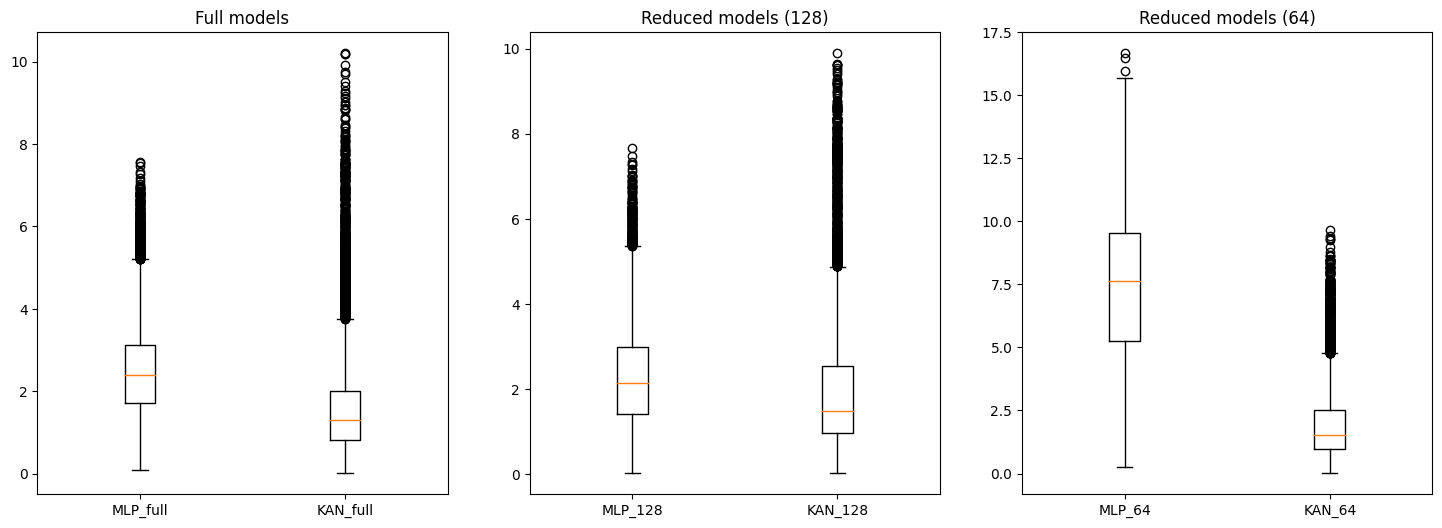

Statistics for  MLP_64
MLP_64: 25th percentile: 5.25 - 50th percentile: 7.65 - 75th percentile: 9.53 - Outliers: 3 (0.02%)
Max distance: 16.67
Statistics for  MLP_128
MLP_128: 25th percentile: 1.41 - 50th percentile: 2.14 - 75th percentile: 2.99 - Outliers: 174 (1.34%)
Max distance: 7.67
Statistics for  MLP_full
MLP_full: 25th percentile: 1.72 - 50th percentile: 2.39 - 75th percentile: 3.11 - Outliers: 388 (2.99%)
Max distance: 7.57
Statistics for  KAN_64
KAN_64: 25th percentile: 0.99 - 50th percentile: 1.55 - 75th percentile: 2.51 - Outliers: 608 (4.69%)
Max distance: 9.67
Statistics for  KAN_128
KAN_128: 25th percentile: 0.97 - 50th percentile: 1.48 - 75th percentile: 2.53 - Outliers: 665 (5.13%)
Max distance: 9.90
Statistics for  KAN_full
KAN_full: 25th percentile: 0.82 - 50th percentile: 1.31 - 75th percentile: 2.00 - Outliers: 903 (6.97%)
Max distance: 10.21


In [79]:
import matplotlib.pyplot as plt

if not perform_evaluation:
    print('Evaluation is disabled')
else:
    data = {
        'MLP_64': mlp_64_distances,
        'MLP_128': mlp_128_distances,
        'MLP_full': mlp_full_distances,
        'KAN_64': kan_64_distances,
        'KAN_128': kan_128_distances,
        'KAN_full': kan_full_distances
    }
    
    # Create boxplots for the results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].boxplot([data['MLP_full'], data['KAN_full']], labels=['MLP_full', 'KAN_full'])
    axes[0].set_title('Full models')
    
    axes[1].boxplot([data['MLP_128'], data['KAN_128']], labels=['MLP_128', 'KAN_128'])
    axes[1].set_title('Reduced models (128)')
    
    axes[2].boxplot([data['MLP_64'], data['KAN_64']], labels=['MLP_64', 'KAN_64'])
    axes[2].set_title('Reduced models (64)')
    
    plt.show()
    
    # Print model statistics: 25th, 50th (median), 75th percentiles, and the amount or percentage of outliers
    for key in data:
        print("====================================")
        print("Statistics for ", key)
        distances = data[key]
        q25, q50, q75 = np.percentile(distances, [25, 50, 75])
        iqr = q75 - q25
        lower_bound = q25 - 1.5 * iqr
        upper_bound = q75 + 1.5 * iqr
        outliers = np.sum((distances < lower_bound) | (distances > upper_bound))
        print(f'{key}: 25th percentile: {q25:.2f} - 50th percentile: {q50:.2f} - 75th percentile: {q75:.2f} - Outliers: {outliers} ({outliers/len(distances)*100:.2f}%)')
        
        # Print max predicted distance
        max_distance = np.max(distances)
        print(f'Max distance: {max_distance:.2f}')
        